In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statistics import mode
from datetime import datetime, timedelta
from scipy.stats import ks_2samp
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import datetime as dt
import timeit
%matplotlib inline

In [2]:
data = pd.read_csv('HW5_final_df.csv').iloc[:,1:]
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merch_state_count_0_by_30,merch_state_amount_0_by_30,merch_state_count_1_by_7,merch_state_amount_1_by_7,merch_state_count_1_by_14,merch_state_amount_1_by_14,merch_state_count_1_by_30,merch_state_amount_1_by_30,weekday_fraud_encoded,state_fraud_encoded
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.033333,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.040022,0.008747
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.033333,0.033333,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.040022,0.002046
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.033333,0.033333,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.040022,0.020811
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.033333,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.040022,0.008747
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.033333,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.040022,0.008747


In [3]:
data.shape

(96397, 486)

### Remove Out-of-Time (OOT) Records

In [4]:
#Remove the first 2 weeks and the last 4 months
mydata = data[(data.Date > '2010-01-14') & (data.Date < '2010-09-01')]
print(mydata.shape)
print("Removed", data.shape[0] - mydata.shape[0], "rows")

(65708, 486)
Removed 30689 rows


### Filter

In [5]:
# include the Fraud label column
# Add a 'RANDOM' column that stores a random number between 0 and 100
mydata_var = mydata.iloc[:, 9:]
mydata_var = mydata_var.drop(['card_merch', 'card_zip', 'card_state', 'merch_zip', 'merch_state'], axis=1)
mydata_var["RANDOM"] = np.random.randint(0, 100, size=len(mydata_var))
mydata_var.head()

,Fraud,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_actual/avg_0,Cardnum_actual/max_0,Cardnum_actual/med_0,...,merch_state_amount_0_by_30,merch_state_count_1_by_7,merch_state_amount_1_by_7,merch_state_count_1_by_14,merch_state_amount_1_by_14,merch_state_count_1_by_30,merch_state_amount_1_by_30,weekday_fraud_encoded,state_fraud_encoded,RANDOM
3338,0,1.0,1,333.470,333.47,333.470,333.47,1.000000,1.000000,1.000000,...,0.000800,0.009524,0.009762,0.002381,0.001714,0.001111,0.000800,0.040022,0.000818,41
3339,0,1.0,1,4.370,4.37,4.370,4.37,1.000000,1.000000,1.000000,...,0.000087,0.000748,0.000562,0.000235,0.000187,0.000110,0.000087,0.040022,0.008747,15
3340,0,1.0,1,271.930,271.93,271.930,271.93,1.000000,1.000000,1.000000,...,0.002921,0.142857,0.142857,0.016484,0.013417,0.007692,0.006261,0.040022,0.002392,33
3341,0,0.0,2,3.995,4.37,3.995,7.99,0.906133,0.828375,0.906133,...,0.000159,0.001488,0.001024,0.000468,0.000340,0.000219,0.000159,0.040022,0.008747,32
3342,0,14.0,1,16.280,16.28,16.280,16.28,1.000000,1.000000,1.000000,...,0.000517,0.047619,0.004655,0.014286,0.001108,0.006667,0.000517,0.040022,0.000835,20


In [6]:
goods = mydata_var[mydata_var.Fraud == 0]
goods.shape

(65017, 473)

In [7]:
bads = mydata_var[mydata_var.Fraud == 1]
bads.shape

(691, 473)

In [8]:
nvars = mydata_var.shape[1]
KSFDR = pd.DataFrame(np.zeros((nvars, 3)))
i = 0
for column in mydata_var:
    #print(i, column)
    KSFDR.loc[i,0] = column
    i = i+1

KSFDR.columns = ['field', 'ks', 'FDR']
KSFDR

,field,ks,FDR
0,Fraud,0.0,0.0
1,Cardnum_day_since,0.0,0.0
2,Cardnum_count_0,0.0,0.0
3,Cardnum_avg_0,0.0,0.0
4,Cardnum_max_0,0.0,0.0
...,...,...,...
468,merch_state_count_1_by_30,0.0,0.0
469,merch_state_amount_1_by_30,0.0,0.0
470,weekday_fraud_encoded,0.0,0.0
471,state_fraud_encoded,0.0,0.0


In [9]:
# calculate univariate KS
i = 0
for column in mydata_var:
    KSFDR['ks'][i] = ks_2samp(goods[column],bads[column])[0]
    i = i+1
KSFDR

<ipython-input-9-eafa9baa7d70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KSFDR['ks'][i] = ks_2samp(goods[column],bads[column])[0]


,field,ks,FDR
0,Fraud,1.000000,0.0
1,Cardnum_day_since,0.293280,0.0
2,Cardnum_count_0,0.337534,0.0
3,Cardnum_avg_0,0.537210,0.0
4,Cardnum_max_0,0.544053,0.0
...,...,...,...
468,merch_state_count_1_by_30,0.102111,0.0
469,merch_state_amount_1_by_30,0.267556,0.0
470,weekday_fraud_encoded,0.142109,0.0
471,state_fraud_encoded,0.382070,0.0


In [10]:
numgoods = len(goods)
numbads = len(bads)
topRows = int(round(len(mydata_var)*0.03))
j = 0
for column in mydata_var:
    temp = mydata_var.sort_values(column,ascending=False)
    temp1 = temp.head(topRows)
    temp2 = temp.tail(topRows)
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j +1

In [11]:
# Sort by average rank
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)
KSFDR

,field,ks,FDR,rank_ks,rank_FDR,average_rank
0,Fraud,1.000000,1.000000,473.0,473.0,473.00
198,card_zip_total_7,0.676203,0.628075,472.0,472.0,472.00
143,card_merch_total_7,0.669932,0.623734,470.0,469.0,469.50
189,card_zip_total_3,0.666594,0.623734,469.0,469.0,469.00
152,card_merch_total_14,0.660560,0.626628,465.0,471.0,468.00
...,...,...,...,...,...,...
46,Cardnum_actual/total_14,0.132744,0.011577,36.0,34.0,35.00
90,Merchnum_actual/max_7,0.160137,0.005789,56.0,13.0,34.50
330,merch_zip_actual/total_30,0.163908,0.002894,62.0,6.0,34.00
408,Merchnum_count_1_by_30,0.111215,0.011577,22.0,34.0,28.00


In [12]:
KSFDR.tail(10)

,field,ks,FDR,rank_ks,rank_FDR,average_rank
385,merch_state_actual/total_30,0.162785,0.011577,59.0,34.0,46.50
462,merch_state_count_0_by_30,0.118109,0.023155,28.0,58.5,43.25
433,card_zip_amount_1_by_30,0.116147,0.023155,24.0,58.5,41.25
101,Merchnum_actual/total_14,0.173720,0.001447,76.0,2.5,39.25
419,card_merch_amount_1_by_14,0.050156,0.026049,3.0,70.0,36.50
46,Cardnum_actual/total_14,0.132744,0.011577,36.0,34.0,35.00
90,Merchnum_actual/max_7,0.160137,0.005789,56.0,13.0,34.50
330,merch_zip_actual/total_30,0.163908,0.002894,62.0,6.0,34.00
408,Merchnum_count_1_by_30,0.111215,0.011577,22.0,34.0,28.00
431,card_zip_amount_1_by_14,0.045573,0.021708,1.0,54.5,27.75


In [13]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    # get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
    # sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
    # return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud 

In [14]:
#KSFDR.to_csv("HW6_KSFDR.csv")

### Wrapper

In [15]:
KSFDR_top80 = KSFDR.iloc[1:, :].head(80)
KSFDR_top80

,field,ks,FDR,rank_ks,rank_FDR,average_rank
198,card_zip_total_7,0.676203,0.628075,472.0,472.0,472.00
143,card_merch_total_7,0.669932,0.623734,470.0,469.0,469.50
189,card_zip_total_3,0.666594,0.623734,469.0,469.0,469.00
152,card_merch_total_14,0.660560,0.626628,465.0,471.0,468.00
253,card_state_total_7,0.664527,0.594790,468.0,465.0,466.50
...,...,...,...,...,...,...
195,card_zip_avg_7,0.570674,0.266281,427.0,365.0,396.00
58,Merchnum_avg_0,0.555946,0.282200,407.0,385.0,396.00
361,merch_state_max_7,0.510237,0.479016,353.0,438.5,395.75
278,merch_zip_avg_0,0.555159,0.282200,405.0,385.0,395.00


In [16]:
X = mydata_var[mydata_var.columns[mydata_var.columns.isin(list(KSFDR_top80.field))]]
X

,Cardnum_max_0,Cardnum_total_0,Cardnum_max_1,Cardnum_total_1,Cardnum_max_3,Cardnum_total_3,Cardnum_avg_7,Cardnum_max_7,Cardnum_total_7,Cardnum_max_14,...,merch_zip_total_7,merch_state_avg_0,merch_state_max_0,merch_state_total_0,merch_state_max_1,merch_state_total_1,merch_state_max_3,merch_state_total_3,merch_state_max_7,merch_state_total_7
3338,333.47,333.47,930.41,1551.02,930.41,1964.73,399.058889,983.66,3591.53,1593.38,...,4879.97,333.470000,333.47,333.47,333.47,333.47,333.47,854.06,983.66,4879.97
3339,4.37,4.37,656.50,660.87,656.50,834.91,13.857361,656.50,997.73,656.50,...,1111.49,4.370000,4.37,4.37,4.37,4.37,27.00,740.84,27.00,1111.49
3340,271.93,271.93,1380.45,2904.08,2472.00,8459.94,569.067059,2472.00,9674.14,2472.00,...,582.94,271.930000,271.93,271.93,278.73,582.94,278.73,582.94,278.73,582.94
3341,4.37,7.99,656.50,664.49,656.50,838.53,13.717123,656.50,1001.35,656.50,...,1115.11,3.995000,4.37,7.99,4.37,7.99,27.00,744.46,27.00,1115.11
3342,16.28,16.28,16.28,16.28,16.28,16.28,16.280000,16.28,16.28,16.28,...,499.62,16.280000,16.28,16.28,16.28,16.28,113.87,130.15,369.47,499.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69041,340.00,580.00,340.00,580.00,340.00,580.00,290.000000,340.00,580.00,625.00,...,580.00,290.000000,340.00,580.00,340.00,580.00,340.00,580.00,340.00,580.00
69042,133.00,233.00,133.00,281.04,133.00,281.04,93.680000,133.00,281.04,381.70,...,1641.38,304.356667,742.00,913.07,742.00,1077.39,742.00,1229.39,742.00,1641.38
69043,759.50,1547.26,759.50,1547.26,759.50,1547.26,798.652000,1250.00,3993.26,1250.00,...,170.00,170.000000,170.00,170.00,170.00,170.00,170.00,170.00,170.00,170.00
69044,100.96,130.90,100.96,130.90,373.10,584.04,571.084000,2271.38,2855.42,2271.38,...,130.90,65.450000,100.96,130.90,100.96,130.90,100.96,130.90,100.96,130.90


In [17]:
y = mydata_var[mydata_var.columns[mydata_var.columns.isin(list(KSFDR.field))]].Fraud
y

3338     0
3339     0
3340     0
3341     0
3342     0
        ..
69041    0
69042    0
69043    0
69044    0
69045    0
Name: Fraud, Length: 65708, dtype: int64

In [18]:
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
sfs_forward = SFS(clf, k_features=nfeatures, forward=True, verbose=2, scoring=fdr, cv=2, n_jobs=-1)
sfs_forward.fit(X, y)
#sfs_backward = SFS(clf, k_features=1, forward=False, verbose=2, scoring=fdr, cv=2, n_jobs=-1)
#sfs_backward.fit(mydata_var, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.6s finished

[2021-05-18 23:11:26] Features: 1/80 -- score: 0.4066515875010472[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.3s finished

[2021-05-18 23:11:42] Features: 2/80 -- score: 0.5166834212951328[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.7s finished

[2021-05-18 23:11:59] Features: 3/80 -- score: 0.5643964145095083[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  77 out o

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=80, n_jobs=-1,
                          scoring=<function fdr at 0x7fc341d33820>, verbose=2)

In [23]:
vars_FS = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(53,)","[0.4028985507246377, 0.41040462427745666]",0.406652,"(card_state_total_3,)",0.016148,0.003753,0.003753
2,"(53, 62)","[0.5449275362318841, 0.4884393063583815]",0.516683,"(card_state_total_3, merch_zip_avg_0)",0.121525,0.028244,0.028244
3,"(53, 55, 62)","[0.5623188405797102, 0.5664739884393064]",0.564396,"(card_state_total_3, card_state_max_7, merch_z...",0.008939,0.002078,0.002078
4,"(53, 55, 62, 70)","[0.6, 0.5664739884393064]",0.583237,"(card_state_total_3, card_state_max_7, merch_z...",0.072125,0.016763,0.016763
5,"(35, 53, 55, 62, 70)","[0.5826086956521739, 0.6098265895953757]",0.596218,"(card_zip_avg_3, card_state_total_3, card_stat...",0.058555,0.013609,0.013609
...,...,...,...,...,...,...,...
76,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.553623188405797, 0.5867052023121387]",0.570164,"(Cardnum_max_0, Cardnum_total_0, Cardnum_max_1...",0.07117,0.016541,0.016541
77,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5855072463768116, 0.5317919075144508]",0.55865,"(Cardnum_max_0, Cardnum_total_0, Cardnum_max_1...",0.115559,0.026858,0.026858
78,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6260869565217392, 0.5115606936416185]",0.568824,"(Cardnum_max_0, Cardnum_total_0, Cardnum_max_1...",0.246383,0.057263,0.057263
79,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5652173913043478, 0.5260115606936416]",0.545614,"(Cardnum_max_0, Cardnum_total_0, Cardnum_max_1...",0.084345,0.019603,0.019603


In [28]:
#list(vars_FS.feature_names)
importance = []
for i in list(vars_FS.feature_names):
    for j in i:
        if j not in importance:
            importance.append(j)
importance

['card_state_total_3',
 'merch_zip_avg_0',
 'card_state_max_7',
 'merch_zip_total_7',
 'card_zip_avg_3',
 'Cardnum_max_7',
 'card_merch_total_7',
 'card_state_max_3',
 'card_state_max_1',
 'merch_state_total_7',
 'card_state_total_1',
 'card_zip_max_3',
 'Merchnum_total_3',
 'card_state_max_14',
 'Cardnum_total_0',
 'card_zip_max_7',
 'card_merch_max_3',
 'Merchnum_avg_0',
 'merch_state_total_1',
 'card_state_max_0',
 'Cardnum_total_1',
 'Merchnum_max_0',
 'card_merch_max_7',
 'merch_state_max_3',
 'card_merch_total_30',
 'card_merch_max_14',
 'card_merch_total_3',
 'card_state_avg_7',
 'card_zip_avg_7',
 'card_zip_total_0',
 'card_zip_total_7',
 'card_zip_max_30',
 'card_state_total_14',
 'merch_state_total_3',
 'Cardnum_avg_7',
 'merch_zip_total_1',
 'card_merch_total_14',
 'merch_zip_max_7',
 'card_state_max_30',
 'Merchnum_max_1',
 'card_state_avg_14',
 'Cardnum_total_7',
 'merch_zip_total_3',
 'card_zip_max_14',
 'card_zip_avg_14',
 'merch_zip_max_0',
 'merch_state_avg_0',
 'card_

In [32]:
vars_30 = importance[:30]
vars_30_df = pd.DataFrame(vars_30, columns = ["feature"])
vars_30_df
#vars_30_df.to_csv("HW6_Wrapper_top30.csv")

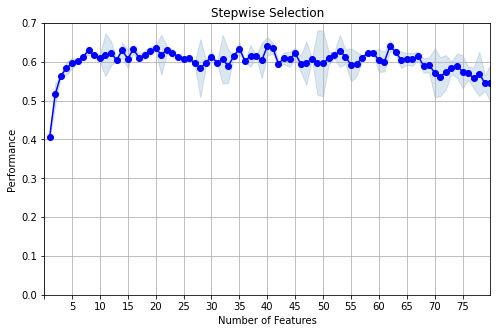

In [33]:
figl = plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev', figsize=(8,5))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0, len(X.columns))
plt.title('Stepwise Selection')
plt.grid()
#plt.savefig("FS_fdr.png")
plt.show()